### Galaxy Zoo Weird & Wonderful Consensus and ML output joint analysis

This notebook includes critical pieces about processing the GZ:W&W consensus answers along with their corresponding Talk based tags alongside ML produced latent space features and anomaly scores. 

In [1]:
## Import necessary modules.

from astropy.io import ascii, fits
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import ast
import csv
from panoptes_client import Panoptes, Project, SubjectSet, Subject
import json
import pprint
from astropy.table import Table
import os
import umap
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import ascii
from shutil import copy2
from astropy.table import Table
import hdbscan

In [2]:
# file that contains the talk comments (i.e., talk comment export from the project)
with open('project-14993-comments_2023-08-02.json', 'r') as infile:
    talk_comments = json.load(infile)

# talk tags export from zooniverse
with open('project-14993-tags_2023-08-02.json', 'r') as infile:
    talk_tags = json.load(infile)

    
# talk tags export from the classic GZ project.
with open('project-5733-tags_2023-11-28.json', 'r') as infile:
    talk_tags_gz = json.load(infile)

FileNotFoundError: [Errno 2] No such file or directory: 'project-14993-comments_2023-08-02.json'

In [3]:
# A helper function that converts the JSON data into a Table for ease of parsing during downstream analysis.
def convert_json_data_to_table(json_data):
    table_data = Table(names=list(json_data[0].keys()), dtype=[type(iii) for iii in list(json_data[0].values())])
    
    for each_entry in json_data:
        if None not in each_entry.values():
            table_data.add_row(each_entry.values())
    
    return table_data

In [5]:
# A helper function that combines various tag combinations that occur in the Talk tag export.
def merge_tags(tag):
    if tag in ['1-spiral', '2-spiral', '3-arm', '3-spiral', 'arm', 'arms', 'single_arm_spiral',
       'so_close', 'sobig', 'spiral', 'spiral-2', 'spiral-arm',
       'spiral-arms', 'spiral-arms-bulge', 'spirals', 'unwinding', 'unwinding_arms',
       'unwinding_spiral', 'galaxy', 'galaxies']:
        return 'spiral'
    elif tag in ['ansae_bar', 'bar', 'bar-lens', 'barlens', 'barred_spiral', 'barred', 'full_bar', 'fullbar']:
        return 'barred'
    elif tag in ['arc', 'arcs']:
        return 'arc'
    elif tag in ['clump', 'clumps', 'clumpy', 'bright_clumps', 'super_bright_clumps', 'star-forming', 'star_formation', 'starburst', 'starforming']:
        return 'clumps'
    elif tag in ['colisional_ring', 'colliding', 'collisonal_ring']:
        return 'collisional_ring'
    elif tag in ['disturbance', 'disturbed','disturbed_arm', 'double', 'double_nucleus', 'double_ring']:
        return 'disturbed'
    elif tag in ['dust-lane', 'dust_lane', 'dustlane']:
        return 'dust-lane'
    elif tag in ['edge', 'edge-on', 'egde']:
        return 'edge-on'
    elif tag in ['einstein_cross', 'gravitatational_lens','gravitation_lens', 'gravitation_lens_candidate', 
                 'gravitational_lens', 'gravitational_lens_candidate','gravitational_lenses', 'gravitational_lensing',
                'lens', 'lenses', 'lensing', 'buried_lens']:
        return 'gravitational_lensing'
    elif tag in ['inner_ring','inter_rings']:
        return 'inner_ring'
    elif tag in ['interacting', 'interacting_galaxies','interaction', 'interesting', 'iregular', 'irregular']:
        return 'interacting_irregular'
    elif tag in ['jellyfish','jellyfish_candidate']:
        return 'jellyfish_candidate'
    elif tag in ['jet', 'jets']:
        return 'jet'
    elif tag in ['meger', 'merge', 'merged', 'merger', 'merging', 'merging_cluster', 'post_merger']:
        return 'merger'
    elif tag in ['tail', 'tidal', 'tidal-tail', 'tidal_interaction',
       'tidal_tail', 'tidal_tails', 'trail']:
        return 'tidal_features'
    elif tag in ['outer_resonant_ring',
       'outer_ring', 'outer_rings']:
        return 'outer_ring'
    elif tag in ['shell', 'shell-galaxy', 'shells']:
        return 'shells'
    elif tag in ['weird','weird-wonderful', 'weird_wonderful', 'wierd', 'wonderful', 'wwgalaxy']:
        return 'WW'
    elif tag in ['overlap', 'overlapping']:
        return 'overlap'
    elif tag in ['possible_asteroid', 'asteroids']:
        return 'asteroid'
    elif tag in ['ring_galaxy', 'ringgalaxy', 'rings', 'possible_ring', 'ringed', 'ring']:
        return 'rings'
    elif tag in ['rps', 'possible_rps']:
        return 'rps'
    
    else: 
        return tag

In [6]:
# getting the table version of the talk comments and talk tags
talk_comments_table = convert_json_data_to_table(talk_comments)
talk_tags_table = convert_json_data_to_table(talk_tags)

processed_tags = np.array([merge_tags(ttt) for ttt in np.array(talk_tags_table['name'])])
talk_tags_table['merged_tags'] = processed_tags

In [7]:
# loading the consensus, GZ-participation based weighted consensus, and the subject information tables

consensus = ascii.read('latest_consensus_aggregation_table.dat')
weigted_consensus = ascii.read('all_ww_data.csv')
subject_information = ascii.read('galaxy-zoo-weird-and-wonderful-subjects.csv', format='csv')

In [8]:
# a visual of the subject information.
subject_information

subject_id,project_id,workflow_id,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at
int64,int64,int64,int64,str235,str106,int64,str23,str20,str23,str23
458021,14993,17619,92123,"{""link"":""https://www.flickr.com/photos/aigle_dore/6672150457"",""origin"":""Flickr"",""license"":""Creative Commons - share adapt attribute"",""image_name"":""6672150457_420d61007d_b.jpg"",""subject_id"":1,""attribution"":""Moyan Brenn""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/5346704c-aadc-4d47-890c-817e43e3b648.jpeg""}",0,--,--,2015-05-25 21:02:58 UTC,2015-05-25 21:02:58 UTC
458021,14993,17617,92123,"{""link"":""https://www.flickr.com/photos/aigle_dore/6672150457"",""origin"":""Flickr"",""license"":""Creative Commons - share adapt attribute"",""image_name"":""6672150457_420d61007d_b.jpg"",""subject_id"":1,""attribution"":""Moyan Brenn""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/5346704c-aadc-4d47-890c-817e43e3b648.jpeg""}",0,--,--,2015-05-25 21:02:58 UTC,2015-05-25 21:02:58 UTC
458022,14993,17619,92123,"{""link"":""https://www.flickr.com/photos/aigle_dore/8300920648"",""origin"":""Flickr"",""license"":""Creative Commons - share adapt attribute"",""image_name"":""8300920648_d4a21bba59_z.jpg"",""subject_id"":2,""attribution"":""Moyan Brenn""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/6309ed81-6ca1-4073-ad66-2a194edefc32.jpeg""}",0,--,--,2015-05-25 21:02:59 UTC,2015-05-25 21:02:59 UTC
458022,14993,17617,92123,"{""link"":""https://www.flickr.com/photos/aigle_dore/8300920648"",""origin"":""Flickr"",""license"":""Creative Commons - share adapt attribute"",""image_name"":""8300920648_d4a21bba59_z.jpg"",""subject_id"":2,""attribution"":""Moyan Brenn""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/6309ed81-6ca1-4073-ad66-2a194edefc32.jpeg""}",0,--,--,2015-05-25 21:02:59 UTC,2015-05-25 21:02:59 UTC
458023,14993,17619,92123,"{""link"":""https://www.flickr.com/photos/hellie55/6713782851"",""origin"":""Flickr"",""license"":""Creative Commons - share adapt attribute"",""image_name"":""6713782851_82fc8c73e5_z.jpg"",""subject_id"":3,""attribution"":""hehaden""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/6614aa29-6e75-4e2a-af18-d031e60bc2ec.jpeg""}",0,--,--,2015-05-25 21:03:01 UTC,2015-05-25 21:03:01 UTC
458023,14993,17617,92123,"{""link"":""https://www.flickr.com/photos/hellie55/6713782851"",""origin"":""Flickr"",""license"":""Creative Commons - share adapt attribute"",""image_name"":""6713782851_82fc8c73e5_z.jpg"",""subject_id"":3,""attribution"":""hehaden""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/6614aa29-6e75-4e2a-af18-d031e60bc2ec.jpeg""}",0,--,--,2015-05-25 21:03:01 UTC,2015-05-25 21:03:01 UTC
458024,14993,17619,92123,"{""link"":""https://www.flickr.com/photos/odoketa/8762013777"",""origin"":""Flickr"",""license"":""Creative Commons - share adapt attribute"",""image_name"":""8762013777_1fa7d91e98_z.jpg"",""subject_id"":4,""attribution"":""David Barber""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/25b892e7-b10f-4d06-a8cf-e6837f6aaa5d.jpeg""}",0,--,--,2015-05-25 21:03:02 UTC,2015-05-25 21:03:02 UTC
458024,14993,17617,92123,"{""link"":""https://www.flickr.com/photos/odoketa/8762013777"",""origin"":""Flickr"",""license"":""Creative Commons - share adapt attribute"",""image_name"":""8762013777_1fa7d91e98_z.jpg"",""subject_id"":4,""attribution"":""David Barber""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/25b892e7-b10f-4d06-a8cf-e6837f6aaa5d.jpeg""}",0,--,--,2015-05-25 21:03:02 UTC,2015-05-25 21:03:02 UTC
458025,14993,17619,92123,"{""link"":""https://www.flickr.com/photos/bevgoodwin/8556948660"",""origin"":""Flickr"",""license"":""Creative Commons - share adapt attribute"",""image_name"":""8556948660_807cb1f8db_z.jpg"",""subject_id"":5,""attribution"":""Beverley Goodwin""}","{""0"":""https://panoptes-up

In [9]:
# computing the chosen fractions and weighted chosen fractions by looping through the loaded tables above.
chosen_fractions = []
weigthed_chosen_fractions = []
for each_subject in tqdm.tqdm(consensus):
    matched_info = weigted_consensus[np.where(weigted_consensus['subject_id'] == each_subject['subject_id'])]
    chosen_fractions.append(matched_info['percent_selected']/100)
    weigthed_chosen_fractions.append(matched_info['normalized_weighted_count']/100)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207589/207589 [00:56<00:00, 3694.47it/s]


In [10]:
# adding the computed fractions as columns to the table.
consensus['selected_fraction'] = np.array(chosen_fractions)
consensus['weighted_selected_fraction'] = np.squeeze(np.array(weigthed_chosen_fractions), axis=1)

In [11]:
# loading the anomaly scores. The three files are due to split processing that was done through the ML pipeline.
# (due to some memory/file number constraints)
anomaly_scores1 = ascii.read('/d1/manth145/WW_Anomaly_Scores/anomaly_scores_MagLim.csv')
anomaly_scores2 = ascii.read('/d1/manth145/WW_Anomaly_Scores/anomaly_scores_MagLim_continued.csv')
anomaly_scores3 = ascii.read('/d1/manth145/WW_Anomaly_Scores/anomaly_scores_MagLim_continued2.csv')

# loading the latent space vectors for each image (each latent vector is 128 in dimensionality).
zhat1 = np.load('/d1/manth145/WW_Anomaly_Scores/z_hat_hsc_MagLim.npy')
zhat2 = np.load('/d1/manth145/WW_Anomaly_Scores/z_hat_hsc_MagLim_continued.npy')
zhat3 = np.load('/d1/manth145/WW_Anomaly_Scores/z_hat_hsc_MagLim_continued2.npy')

In [12]:
anomaly_scores1[np.where(anomaly_scores1['filename']==41223456884296882)]

counter,filename,anomaly_score,image_score,feature_score
int64,int64,float64,float64,float64
454442,41223456884296882,221.16037,189.56734,347.53247


In [12]:
# looping through the anomaly score and latent space information to generate one file with all the info.

anomaly_scores_subset = []
image_scores_subset = []
feature_scores_subset = []
latent_vectors = []
for each_subject in tqdm.tqdm(consensus):
    filename = int(ast.literal_eval(np.array(subject_information[np.where(subject_information['subject_id'] == each_subject['subject_id'])]['metadata'])[0])['filename'].strip('.png'))
#     filename = int(each_subject['filename'])
    cond = np.where(anomaly_scores1['filename']==filename)
    anom_score = anomaly_scores1[cond]
    latent_z = zhat1[cond]
    if np.size(anom_score)==0:
        cond = np.where(anomaly_scores2['filename']==filename)
        anom_score = anomaly_scores2[cond]
        latent_z = zhat2[cond]
        
        if np.size(anom_score) == 0:
            cond = np.where(anomaly_scores3['filename']==filename)
            anom_score = anomaly_scores3[cond]
            latent_z = zhat3[cond]
    if np.array(anom_score).size!=0:
        anomaly_scores_subset.append(anom_score['anomaly_score'].value.item())
        image_scores_subset.append(anom_score['image_score'].value.item())
        feature_scores_subset.append(anom_score['feature_score'].value.item())
        latent_vectors.append(list(np.squeeze(latent_z, axis=0)))
    else:
        anomaly_scores_subset.append(-99)
        image_scores_subset.append(-99)
        feature_score_subset.append(-99)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207589/207589 [03:32<00:00, 976.15it/s]


In [13]:
# assigning dedicated columns with the above matched info into a "uber" table.

consensus['anomaly_scores'] = np.array(anomaly_scores_subset)
consensus['latent_vector'] = np.array(latent_vectors)
consensus['image_scores'] = np.array(image_scores_subset)
consensus['feature_scores'] = np.array(feature_scores_subset)

In [16]:
# a sample visual of one subject ID and its corresponding table entry.
consensus[np.where(consensus['subject_id']==86394680)]

subject_id,count,selected_count,unique_user_count,selected_fraction [1],weighted_selected_fraction,anomaly_scores,latent_vector [128],image_scores,feature_scores
int64,int64,int64,int64,float64,float64,float64,float32,float64,float64
86394680,14,1,13,0.07690000000000001,0.05,221.16037,0.36666358 .. 0.23213907,189.56734,347.53247


In [13]:
# Only a subset of the subjects have been discussed in Talk. As such, here we construct
# a talk comments table and summarize them.

unique_talk_comment_subjects = np.unique(talk_comments_table['comment_focus_id'])
talk_comment_summary_table = Table(names=['subject_id', 'count', 'selected_count', 'unique_user_count', 
                                          'selected_fraction', 'weighted_selected_fraction', 'anomaly_scores', 'latent_vector',
                                          'image_scores', 'feature_scores',
                                          'num_talk_comments', 'talk_tags'],
                                  dtype = [int, int, int, int, 
                                           float, float, float, list,
                                           float, float,
                                           int, list])

In [14]:
# looping through the talk table to match relevant information for analysis.
for each_unique_talk_subject in unique_talk_comment_subjects:
    consensus_info = consensus[np.where(consensus['subject_id'] == each_unique_talk_subject)]
    if np.size(consensus_info)!=0:
        filename = int(ast.literal_eval(np.array(subject_information[np.where(subject_information['subject_id'] == each_unique_talk_subject)]['metadata'])[0])['filename'].strip('.png'))
        this_talk_comments = talk_comments_table[np.where(talk_comments_table['comment_focus_id'] == each_unique_talk_subject)]
        this_tags = talk_tags_table[np.where(talk_tags_table['taggable_id'] == each_unique_talk_subject)]
        required_information = list(np.array(consensus_info)[0]) + [len(this_talk_comments), list(np.array(this_tags['merged_tags']))]
        talk_comment_summary_table.add_row(required_information)

In [15]:
# a visual of the constructed talk comment summary table.
talk_comment_summary_table

subject_id,count,selected_count,unique_user_count,selected_fraction,weighted_selected_fraction,anomaly_scores,latent_vector,image_scores,feature_scores,num_talk_comments,talk_tags
int64,int64,int64,int64,float64,float64,float64,object,float64,float64,int64,object
86394739,19,13,18,0.6667000000000001,0.6667000000000001,426.1513,[ 0.1063259 0.08373854 2.1216986 1.5118431 0.14912623 0.6212141 0.72745067 0.7690715 -0.728338 -0.64137536 0.15370159 -1.400284 0.48410168 -0.12946165 2.248077 -2.3700345 -0.05843718 -1.7496102 -0.78384143 0.67817533 -0.79793525 -0.3964902 0.34444198 -0.84649855 0.8294454 -0.45916006 -0.44358498 -0.54495305 -0.541717 -0.4218117 -1.4611852 1.0536151 -1.2465807 0.14030857 0.13268274 -0.9218208 -1.8025707 -1.4526907 -1.930795 -0.9204104 1.3445581 1.5829756 -0.6781153 -0.603107 -1.7382747 -0.31214648 2.3914375 -0.40294045 -0.22816199 0.14514455 -0.55840015 1.6165718 -0.6409636 0.0288984 -2.530843 -1.6234622 -0.2977928 0.7321711 -0.87601143 2.5997293 -1.7214469 0.5975857 -0.08823831 -0.35554782 -1.121045 0.6070541 -0.30613193 -1.3530954 -0.35514674 -0.6499405 1.702578 1.1792881 -1.2603308 0.43868294 1.9328358 1.2115266 -0.85994387 -2.0012362 -0.08684991 -1.5700442 -1.4997113 -0.16067511 -1.5810192 -0.66413176 -0.91859674 -0.28148085 0.63521403 1.222421 -0.36538708 0.93737316 0.6546492 -0.28707358 1.0233833 2.1530797 2.5738683 0.51503104 0.7273261 -2.0439367 2.468162 -0.55338967 -1.1458507 1.1529253 -1.0586236 -1.512156 0.04924466 -0.31489366 -0.83360755 1.632178 -0.6022275 0.1049349 1.7265126 -0.77208483 0.36968622 -0.15209672 -1.6580341 -1.5704165 -0.23930608 -2.2606502 -1.8569286 -0.70610785 -1.9426696 -0.804777 -1.4621589 -0.23080246 -0.38292608 0.47167528 0.8295991 1.242701 ],251.73532,1123.8152,1,[]
86394741,19,7,17,0.4118,0.3636,265.51276,[ 0.46937773 -0.96874315 1.991863 0.29792023 1.5184281 -0.46955937 0.79281765 -0.20464121 -0.5492029 1.3033551 -0.014862 -0.43180963 -0.3360216 1.2857075 -1.4443232 -0.9416567 -0.16671936 -0.622217 -0.82412434 2.1903384 -1.1430516 -0.79301023 1.8250401 0.68642 -0.7083873 -1.0613748 0.4832438 0.3084182 0.57767004 0.06560827 0.557949 0.81003845 -0.9393284 -1.0936878 0.4290041 0.26216918 -0.96031195 1.2395976 -2.7139516 -1.9787457 -0.3355395 2.0405734 -1.3357844 -1.4569575 -2.1641657 1.0716795 -0.02152003 -0.4265061 1.6236842 1.6594598 0.72489715 0.9912511 -2.5681727 0.28605303 -0.65711427 0.34582132 -0.4446996 1.3417112 -0.07292832 2.0276244 -0.65977365 0.3309641 0.37269962 -0.7749805 -1.4096146 -1.4466015 1.2368417 -0.3684762 -1.1491039 -0.6089061 1.2830286 2.4218662 -3.1188498 -0.52767855 -0.4240839 -2.925236 0.16273735 0.01309559 -1.0807542 -0.04977455 -0.02567631 -0.5869709 -0.7166467 2.5305731 0.08224145 1.9408087 1.2955333 0.3259095 -1.1331086 -1.0300287 -0.6549302 -1.101561 -0.6734366 1.9075679 1.6589077 -0.24133982 -0.74956554 -0.78266996 1.4500077 -2.0907986 0.17888401 0.8296581 -0.59444845 -1.0198609 1.5842851 -0.7505963 -1.5641425 2.2101836 1.5172004 -0.40710065 -1.2363744 0.3538876 -0.56930816 0.59528434 -2.1638062 -2.958958 0.76191974 -0.6253096 -1.1100652 1.607328 -1.5731863 -0.75200164 -0.6194727 -0.37008402 -0.38007346 -1.1116333 -0.48596293 0.8170764 ],192.04192,559.39606,2,[]
86394750,17,5,14,0.35710000000000003,0.3,365.1073,[-0.7299197 -1.8083005 0.5213726 -0.9195727 3.135019 1.4963509 1.7386351 2.0415885 0.2626146 -0.7904755 -0.19074874 0.6805941 -3.1344397 -1.5218774 0.5522657 -0.14561799 0.99939287 -1.642946 -1.8335251 0.33090848 -0.4082724 -0.4664344 1.6392276 1.2723681 0.5794429 -2.1552033 -0.5630013 0.2492813 -0.9960022 0.83027244 -2.8586836 0.6567613 0.36146012 -1.9456366 -0.60108286 -1.2050543 -1.1893656 2.4638698 -2.7665124 -1.6903749 0.7241986 2.2909293 -1.1275325 -1.3457587 -3.1465101 1.2074277 2.53084 1.0556302 0.53552955 0.36894754 -1.5029309 -0.9190809 -0.84310514 0.9986694 -2.0578475 0.26325297 -1.6749859 0.10729817 -0.7172176 5.1360207 -1.067606 -2.2844124 -2.3616688 -1.7764096 -0.7221934 -1.9831514 -0.02278655 -0.5292409 -1.2473526 0.9

In [17]:
# defining some subsets for various astrophysically relevant categories (mergers, ring, gravitational lens, etc).

mergers_cond = ['merger' in kkk for kkk in talk_comment_summary_table['talk_tags']]
grav_cond = ['gravitational_lensing' in kkk for kkk in talk_comment_summary_table['talk_tags']]
tidal_cond = ['tidal_features' in kkk for kkk in talk_comment_summary_table['talk_tags']]
ring = ['rings' in kkk for kkk in talk_comment_summary_table['talk_tags']]
ww_cond = ['WW' in kkk for kkk in talk_comment_summary_table['talk_tags']]
barred_cond = ['barred' in kkk for kkk in talk_comment_summary_table['talk_tags']]
arc_cond = ['arc' in kkk for kkk in talk_comment_summary_table['talk_tags']]
clumpy_cond = ['clumps' in kkk for kkk in talk_comment_summary_table['talk_tags']]

wd = np.where(['white_dwarf_candidate' in kkk for kkk in talk_comment_summary_table['talk_tags']])[0]
sn = np.where(['supernova' in kkk for kkk in talk_comment_summary_table['talk_tags']])[0]
asteroid = np.where(['asteroid' in kkk for kkk in talk_comment_summary_table['talk_tags']])[0]

mergers = np.where(mergers_cond)[0]
grav = np.where(grav_cond)[0]
tidal = np.where(tidal_cond)[0]
ring = np.where(ring)[0]
WW = np.where(ww_cond)[0]
barred = np.where(barred_cond)[0]
arc = np.where(arc_cond)[0]
clumpy = np.where(clumpy_cond)[0]



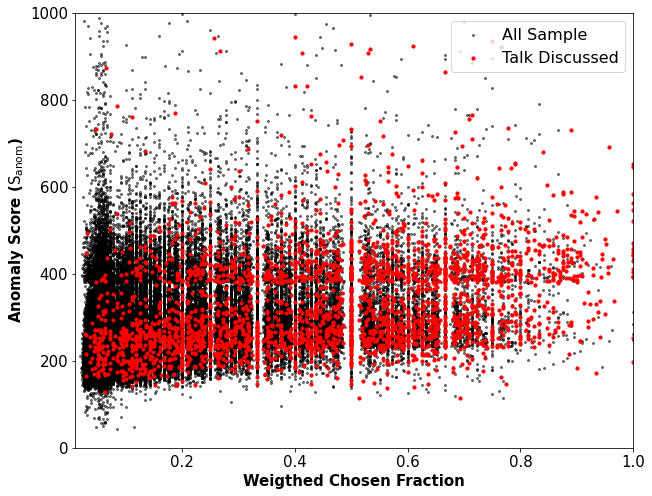

In [28]:
# A plot that shows the anomaly score vs. weighted chosen fraction (Figure 2a).

plt.figure(figsize=[10,8])

plt.scatter(consensus['weighted_selected_fraction'], consensus['anomaly_scores'], marker='o', s=4, color='black', alpha=0.5, label='All Sample')

plt.scatter(talk_comment_summary_table['weighted_selected_fraction'], talk_comment_summary_table['anomaly_scores'], marker='o', s=10, color='red', label='Talk Discussed')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Weigthed Chosen Fraction', fontsize=15, weight='bold')
plt.ylabel('Anomaly Score ($\mathrm{S_{anom}}$)', fontsize=15, weight='bold')
plt.ylim([0,1000])
plt.xlim([0.01,1])
plt.legend(loc=1, fontsize=16)
plt.show()

/tmp/ipykernel_498231/3179644364.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize=16)


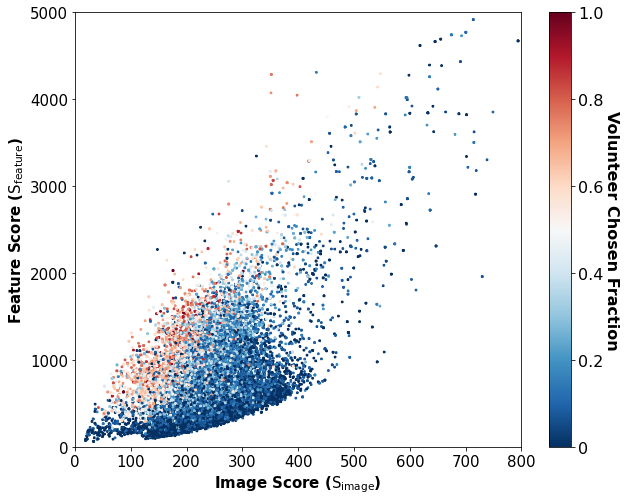

In [29]:
# Producing a figure of feature score vs. image score, color coded by the volunteer chosen fraction (supplemental figure)

plt.figure(figsize=[10,8])

rnd_inds = np.random.choice(np.arange(len(weigted_consensus)).astype(int), len(weigted_consensus))
# randomizing the order at which points are shown .. otherwise the trend gets buried in opacity.


c = plt.scatter(consensus[rnd_inds]['image_scores'], consensus[rnd_inds]['feature_scores'], c=consensus[rnd_inds]['selected_fraction'], vmin=0, vmax=1, marker='x', s=4, cmap='RdBu_r', alpha=1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Image Score ($\mathrm{S_{image}}$)', fontsize=15, weight='bold')
plt.ylabel('Feature Score ($\mathrm{S_{feature}}$)', fontsize=15, weight='bold')

plt.xlim([0,800])
plt.ylim([0,5000])

cbar = plt.colorbar(c)
# cbar.ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize=16)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Volunteer Chosen Fraction', fontsize=16, rotation=270, weight='bold')
plt.show()

/tmp/ipykernel_498231/244149290.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize=16)


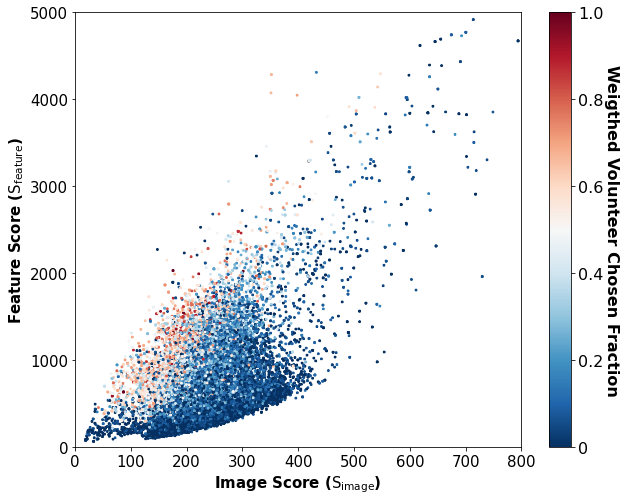

In [30]:
# same as figure above, but color coding the points with the weighted chosen fraction (Figure 2b)

plt.figure(figsize=[10,8])

c = plt.scatter(consensus[rnd_inds]['image_scores'], consensus[rnd_inds]['feature_scores'], c=consensus[rnd_inds]['weighted_selected_fraction'], vmin=0, vmax=1, marker='x', s=4, cmap='RdBu_r', alpha=1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Image Score ($\mathrm{S_{image}}$)', fontsize=15, weight='bold')
plt.ylabel('Feature Score ($\mathrm{S_{feature}}$)', fontsize=15, weight='bold')

plt.xlim([0,800])
plt.ylim([0,5000])

cbar = plt.colorbar(c)
# cbar.ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize=16)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Weigthed Volunteer Chosen Fraction', fontsize=16, rotation=270, weight='bold')
plt.show()

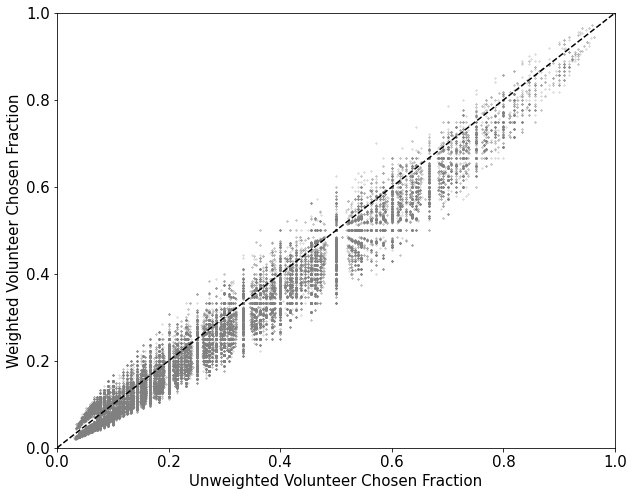

In [61]:
# A figure showing the relationship between unewighted and volunteer experience weighted chosen fractions (supplemental figure).

plt.figure(figsize=[10,8])


plt.scatter(consensus[rnd_inds]['selected_fraction'], consensus[rnd_inds]['weighted_selected_fraction'], marker='x', s=2, color='gray', alpha=0.25)
plt.plot(np.arange(0,1.5,0.1), np.arange(0,1.5,0.1), linestyle='--', color='black')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Unweighted Volunteer Chosen Fraction', fontsize=15)
plt.ylabel('Weighted Volunteer Chosen Fraction', fontsize=15)

plt.xlim([0,1])
plt.ylim([0,1])

plt.show()

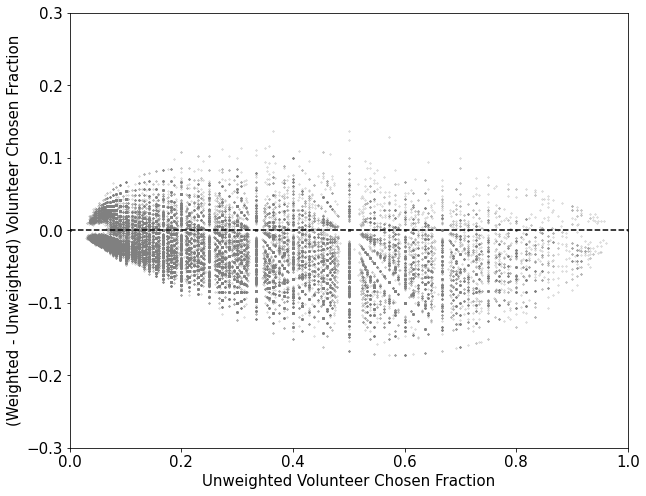

In [68]:
# A figure showing the relationship between the difference unewighted and volunteer experience weighted chosen fractions (supplemental figure).

plt.figure(figsize=[10,8])


difference = consensus['weighted_selected_fraction']-consensus['selected_fraction'][:,0]
plt.scatter(consensus['selected_fraction'], difference, marker='x', s=2, color='gray', alpha=0.25)

plt.axhline(y=0, linestyle='--',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Unweighted Volunteer Chosen Fraction', fontsize=15)
plt.ylabel('(Weighted - Unweighted) Volunteer Chosen Fraction', fontsize=15)

plt.xlim([0,1])
plt.ylim([-0.3,0.3])

plt.show()

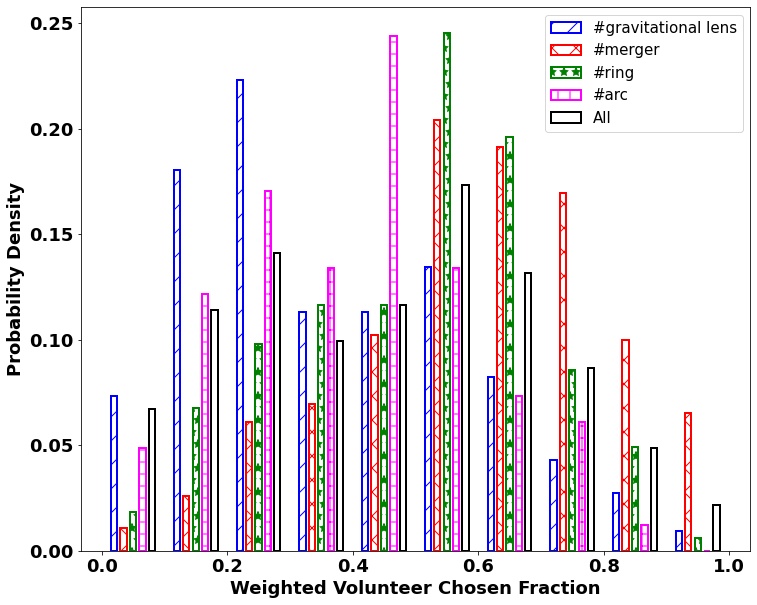

In [33]:
# Distribution of weighted volunteer chosen fractions for various subjects tagged into 
# different categories (see legend; supplementary figure)

fig = plt.figure(figsize=[12,10])
bins = np.arange(0,1.1,0.1)

for each_category, color, jitter, labels, hatch in zip([grav, mergers, ring, arc], ['blue','red','green','magenta'], [-0.03, -0.015, 0, 0.015], ['#gravitational lens', '#merger', '#ring', '#arc'], ['/', 'x', '*', '+']):
    hist_array, bins = np.histogram(talk_comment_summary_table[each_category]['weighted_selected_fraction'], bins=bins)
    plt.bar(((bins[:-1] + bins[1:]) / 2) + jitter, hist_array/np.max(np.cumsum(hist_array)), width=0.01, align='center', facecolor='None',edgecolor=color, label=labels, linewidth=2, hatch=hatch)

hist_array, bins = np.histogram(talk_comment_summary_table['weighted_selected_fraction'], bins=bins)
plt.bar(((bins[:-1] + bins[1:]) / 2) + 0.03, hist_array/np.max(np.cumsum(hist_array)), width=0.01, align='center', facecolor='None',edgecolor='black', label='All', linewidth=2)

    
plt.xticks(fontsize=18, weight='bold')
plt.yticks(fontsize=18, weight='bold')
plt.xlabel('Weighted Volunteer Chosen Fraction', fontsize=18, weight='bold')
plt.ylabel('Probability Density', fontsize=18, weight='bold')
plt.legend(fontsize=15)
plt.show()

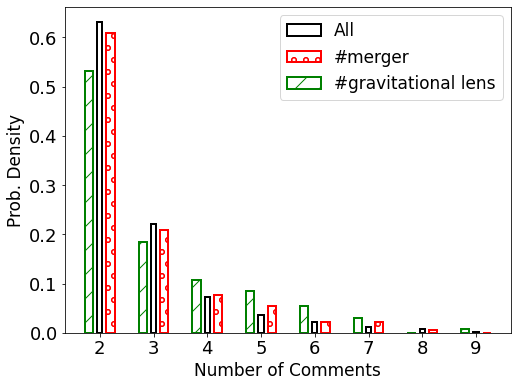

In [35]:
# Distribution of the number of comments for two talk tag categories (supplementary figure)

figure = plt.figure(figsize=[8,6])
hist_array,bins = np.histogram(talk_comment_summary_table['num_talk_comments'], bins=np.arange(2,11,1))
plt.bar(((bins[:-1] + bins[1:]) / 2), hist_array/np.max(np.cumsum(hist_array)), width=0.1, align='center', color='None',edgecolor='black', label='All', linewidth=2)

hist_array,bins = np.histogram(talk_comment_summary_table[mergers]['num_talk_comments'], bins=np.arange(2,11,1))
plt.bar(((bins[:-1] + bins[1:]) / 2)+0.2, hist_array/np.max(np.cumsum(hist_array)), width=0.15, align='center', color='None',edgecolor='red', label='#merger', linewidth=2, hatch='o')

hist_array,bins = np.histogram(talk_comment_summary_table[grav]['num_talk_comments'], bins=np.arange(2,11,1))
plt.bar(((bins[:-1] + bins[1:]) / 2)-0.2, hist_array/np.max(np.cumsum(hist_array)), width=0.15, align='center', color='None',edgecolor='green', label='#gravitational lens', linewidth=2, hatch='/')


plt.xticks(((bins[:-1] + bins[1:]) / 2), labels=(((bins[:-1] + bins[1:]) / 2)-0.5).astype(int),fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Comments', fontsize=17)
plt.ylabel('Prob. Density', fontsize=17)
plt.legend(fontsize=17)
# plt.x


### Latent space based exploration alongside other quantiative parameters

In [34]:
# setting up the UMAP projection and letting it find the optimized projection.
fit = umap.UMAP(random_state=1234,n_components=5,learning_rate=0.001,verbose=True,n_epochs=1000)
umap_components = fit.fit_transform(np.array(consensus['latent_vector']))

UMAP(learning_rate=0.001, n_components=5, n_epochs=1000, random_state=1234, verbose=True)
Wed Jun 19 08:37:47 2024 Construct fuzzy simplicial set
Wed Jun 19 08:37:47 2024 Finding Nearest Neighbors
Wed Jun 19 08:37:47 2024 Building RP forest with 28 trees
Wed Jun 19 08:37:48 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	Stopping threshold met -- exiting after 6 iterations
Wed Jun 19 08:38:02 2024 Finished Nearest Neighbor Search
Wed Jun 19 08:38:04 2024 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Wed Jun 19 08:48:05 2024 Finished embedding


In [35]:
# using the above learnt UMAP projection, 
# we can project the talk discussed subjects into the same latent space for visualization.
talk_tagged_components = fit.transform(np.array([list(zzz) for zzz in talk_comment_summary_table['latent_vector']]))

Wed Jun 19 08:48:09 2024 Worst tree score: 0.18931639
Wed Jun 19 08:48:09 2024 Mean tree score: 0.19484500
Wed Jun 19 08:48:09 2024 Best tree score: 0.19900380
Wed Jun 19 08:48:11 2024 Forward diversification reduced edges from 3113835 to 807559
Wed Jun 19 08:48:13 2024 Reverse diversification reduced edges from 807559 to 807559
Wed Jun 19 08:48:13 2024 Degree pruning reduced edges from 1023054 to 1014537
Wed Jun 19 08:48:13 2024 Resorting data and graph based on tree order
Wed Jun 19 08:48:13 2024 Building and compiling search function


Epochs completed:   0%|            0/333 [00:00]

In [36]:
# concatenating the entire array of anomaly scores for simplicity.
concatenated_anomaly_scores = np.concatenate([anomaly_scores1, anomaly_scores2, anomaly_scores3])

# defining some subsets (based on anomaly score threshold) 
#so that we can just look at these in the UMAP visuals.

highly_anomalous_in_umap = np.where((umap_components[:,1]<2.5) & (consensus['anomaly_scores']>=np.percentile(concatenated_anomaly_scores['anomaly_score'], 99)))[0]
highly_anomalous = np.where(consensus['anomaly_scores']>=np.percentile(concatenated_anomaly_scores['anomaly_score'], 99))[0]
non_anomalous = np.where(consensus['anomaly_scores']<np.percentile(concatenated_anomaly_scores['anomaly_score'], 68))[0]
moderately_anomalous = np.where((consensus['anomaly_scores']>=np.percentile(concatenated_anomaly_scores['anomaly_score'], 68)) & 
                                 (consensus['anomaly_scores']<np.percentile(concatenated_anomaly_scores['anomaly_score'], 99)))[0]

# defining some subsets based on the weighted chosen fraction for visualization purposes.
high_selection_fraction = np.where(consensus['weighted_selected_fraction']>=0.5)[0]
cf_times_feature_score = np.array(consensus['feature_scores']) * consensus['weighted_selected_fraction']
cf_times_anom_score = np.array(consensus['anomaly_scores']) * consensus['weighted_selected_fraction']
high_combined_score = np.where(cf_times_feature_score>=300)[0]
high_combined_anom_score = np.where(cf_times_anom_score>=120)[0]

/tmp/ipykernel_498231/393738846.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks().astype(float),fontsize=15)
/tmp/ipykernel_498231/393738846.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks().astype(float),fontsize=15)
/tmp/ipykernel_498231/393738846.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(ax.get_zticks().astype(int),fontsize=15)


Text(0.5, 0, 'UMAP3')

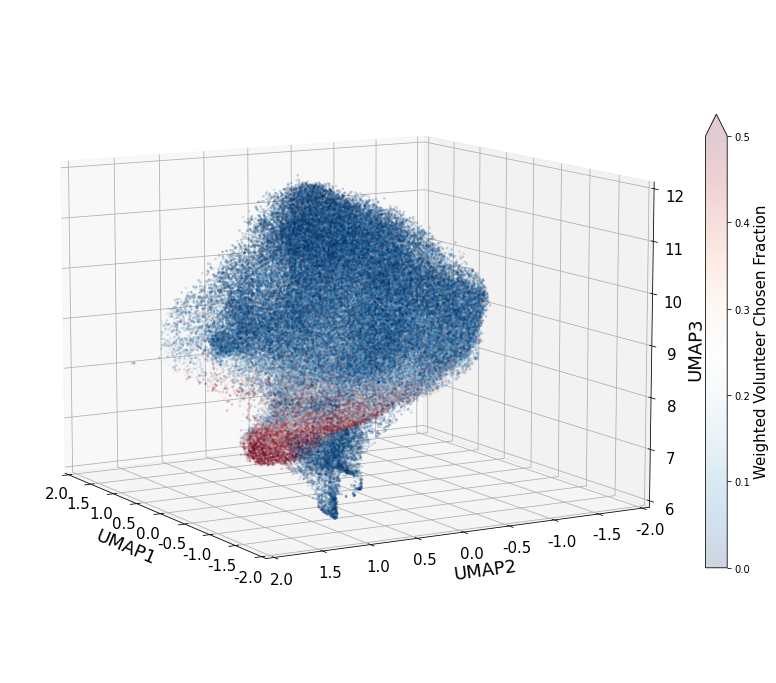

In [78]:
## A 3D plot showing 3 UMAP components and color coding the data points based on different metrics.
## Please uncomment some portions of the code that are relevant to generate various kinds of plots.
## the subset is indicated e.g., [non_anomalous] as defined above.
## the color coding can be indicated by whichever column one wishes to see e.g., consensus['image_scores']

%matplotlib inline
fig = plt.figure(figsize=[10,10])
ax = Axes3D(fig,azim=150,elev=10, auto_add_to_figure=False)
fig.add_axes(ax)

# c = ax.scatter(umap_components[:,0],umap_components[:,1],umap_components[:,2], c=consensus['weighted_selected_fraction'], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.2, vmax=0.5, vmin=0)

# c = ax.scatter(umap_components[highly_anomalous,0],umap_components[highly_anomalous,1],umap_components[highly_anomalous,2], c=consensus[highly_anomalous]['weighted_selected_fraction'], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=0.5, vmin=0)

# c = ax.scatter(umap_components[non_anomalous,0],umap_components[non_anomalous,1],umap_components[non_anomalous,2], c=consensus[non_anomalous]['weighted_selected_fraction'], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.2, vmax=0.5, vmin=0)

c = ax.scatter(umap_components[moderately_anomalous,0],umap_components[moderately_anomalous,1],umap_components[moderately_anomalous,2], c=consensus[moderately_anomalous]['weighted_selected_fraction'], 
           marker='x', s=3, cmap='RdBu_r', alpha=0.2, vmax=0.5, vmin=0)

# c = ax.scatter(umap_components[high_selection_fraction,0],umap_components[high_selection_fraction,1],umap_components[high_selection_fraction,2], c=consensus[high_selection_fraction]['anomaly_scores'], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=np.percentile(consensus['anomaly_scores'], 95), vmin=np.percentile(consensus['anomaly_scores'], 5))

# c = ax.scatter(umap_components[high_selection_fraction,0],umap_components[high_selection_fraction,1],umap_components[high_selection_fraction,2], c=consensus[high_selection_fraction]['feature_scores'], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=np.percentile(consensus['feature_scores'], 95), vmin=np.percentile(consensus['feature_scores'], 5))

# c = ax.scatter(umap_components[high_selection_fraction,0],umap_components[high_selection_fraction,1],umap_components[high_selection_fraction,2], c=consensus[high_selection_fraction]['image_scores'], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=np.percentile(consensus['image_scores'], 95), vmin=np.percentile(consensus['image_scores'], 5))


# c = ax.scatter(umap_components[:,0],umap_components[:,1],umap_components[:,2], c=consensus['anomaly_scores'], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=np.percentile(consensus['anomaly_scores'], 95), vmin=np.percentile(consensus['anomaly_scores'], 5))

# c = ax.scatter(umap_components[:,0],umap_components[:,1],umap_components[:,2], c=consensus['image_scores'], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=np.percentile(consensus['image_scores'], 95), vmin=np.percentile(consensus['image_scores'], 5))

# c = ax.scatter(umap_components[:,0],umap_components[:,1],umap_components[:,2], c=consensus['feature_scores'], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=np.percentile(consensus['feature_scores'], 95), vmin=np.percentile(consensus['feature_scores'], 5))

# c = ax.scatter(umap_components[:,0],umap_components[:,1],umap_components[:,2], c=cf_times_feature_score, 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=np.percentile(cf_times_feature_score, 95), vmin=np.percentile(cf_times_feature_score, 5))

# c = ax.scatter(umap_components[high_combined_score,0],umap_components[high_combined_score,1],umap_components[high_combined_score,2], 
#            marker='x', s=3, color='black')

# c = ax.scatter(umap_components[:,0],umap_components[:,1],umap_components[:,2], c=cf_times_anom_score, 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=np.percentile(cf_times_anom_score, 95), vmin=np.percentile(cf_times_anom_score, 5))

# c = ax.scatter(umap_components[high_combined_anom_score,0],umap_components[high_combined_anom_score,1],umap_components[high_combined_anom_score,2], c=cf_times_anom_score[high_combined_anom_score], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=np.percentile(cf_times_anom_score, 95), vmin=np.percentile(cf_times_anom_score, 5))


# c = ax.scatter(umap_components[:,0],umap_components[:,1],umap_components[:,2], c=consensus['image_scores'], 
#            marker='x', s=3, cmap='RdBu_r', alpha=0.5, vmax=np.percentile(consensus['image_scores'], 95), vmin=np.percentile(consensus['image_scores'], 5))



### Uncomment the below to plot the different talk category based images in the UMAP space.

# mergers, grav, ring, barred, arc
# for shapes, inds, labels, color, ms in zip(['x', 's', 'd', '^', '<', 'o'], [grav, mergers, barred,wd, sn, asteroid], 
#                                 ['#gravitational lens', '#merger', '#barred', '#WD', '#SN','#asteroid'], ['darkblue', 'red', 'darkgreen', 'black', 'orange', 'cyan'], [5, 4, 4, 10, 10, 4]):
#     ax.plot(talk_tagged_components[inds,0],talk_tagged_components[inds,1],talk_tagged_components[inds,2], marker=shapes,
#         markersize=ms, color=color, linestyle='None', alpha=0.5, label=labels)

cbar = plt.colorbar(c,fraction=0.03, pad=0.04, extend='max')
cbar.set_label('Weighted Volunteer Chosen Fraction', fontsize=15)

ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_zlim([6,12])

ax.set_xticklabels(ax.get_xticks().astype(float),fontsize=15)
ax.set_yticklabels(ax.get_yticks().astype(float),fontsize=15)
ax.set_zticklabels(ax.get_zticks().astype(int),fontsize=15)

ax.set_xlabel('UMAP1',fontsize=18, labelpad=10)
ax.set_ylabel('UMAP2',fontsize=18, labelpad=10)
ax.set_zlabel('UMAP3',fontsize=18)


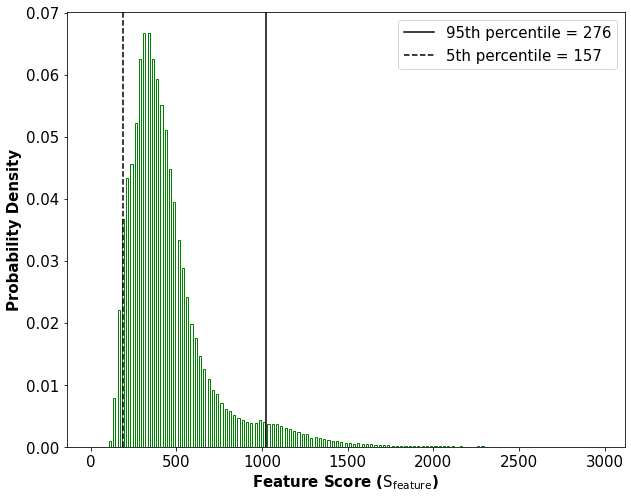

In [21]:
# Histogram of the Feature score 

fig = plt.figure(figsize=[10,8])
bins = np.arange(0,3000,25)


hist_array, bins = np.histogram(consensus['feature_scores'], bins=bins)
plt.bar(((bins[:-1] + bins[1:]) / 2) , hist_array/np.max(np.cumsum(hist_array)), 
        width=12.5, align='center', color='None',edgecolor='green', linewidth=1)


plt.axvline(x=np.percentile(consensus['feature_scores'], 95), linestyle='-', color='black', label='95th percentile = %d'%(np.percentile(consensus['image_scores'], 95)))
plt.axvline(x=np.percentile(consensus['feature_scores'], 5), linestyle='--', color='black', label='5th percentile = %d'%(np.percentile(consensus['image_scores'], 5)))
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Feature Score ($\mathrm{S_{feature}}$)', fontsize=15, weight='bold')
plt.ylabel('Probability Density', fontsize=15, weight='bold')
plt.legend(fontsize=15)
# plt.yscale('log')
plt.show()

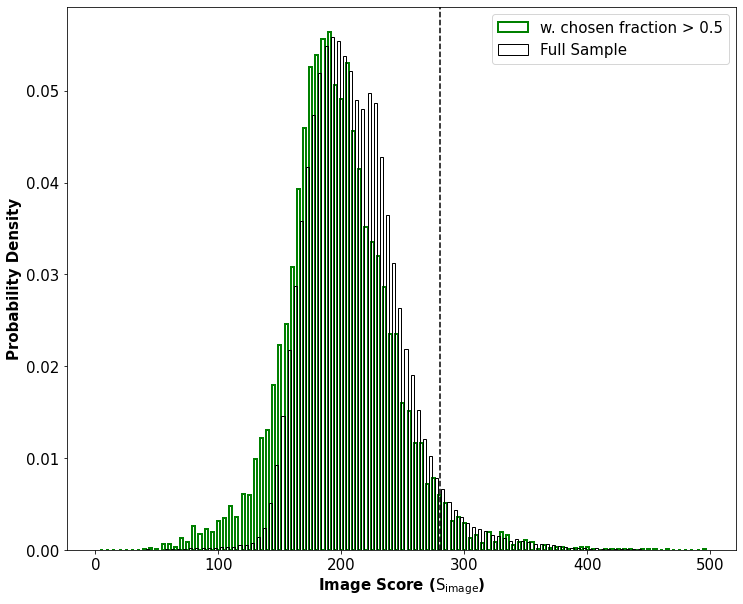

In [71]:
## A histogram of the image scores for the entire sample and a subset.

fig = plt.figure(figsize=[12,10])
bins = np.arange(0,500,5)


hist_array, bins = np.histogram(consensus[high_selection_fraction]['image_scores'], bins=bins)
plt.bar(((bins[:-1] + bins[1:]) / 2) + 2.5, hist_array/np.max(np.cumsum(hist_array)), width=2.5, align='center', color='None',edgecolor='green', label='w. chosen fraction > 0.5', linewidth=2)


hist_array, bins = np.histogram(consensus['image_scores'], bins=bins)
plt.bar(((bins[:-1] + bins[1:]) / 2), hist_array/np.max(np.cumsum(hist_array)), width=2.5, align='center', color='None',edgecolor='black', label='Full Sample', linewidth=1)

plt.axvline(x=np.percentile(concatenated_anomaly_scores['image_score'], 99), linestyle='--', color='black')

    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Image Score ($\mathrm{S_{image}}$)', fontsize=15, weight='bold')
plt.ylabel('Probability Density', fontsize=15, weight='bold')
plt.legend(fontsize=15)
plt.show()